# Atmospheric retrieval on synthetic data with Hamiltonian MCMC
### Multi-layer atmosphere with just a single species for now $O_2$
### Now with `numpyro`

Let's simulate a retrieval with synthetic data.


May 2020

In [1]:
import astropy.units as u
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import hapi
hapi.db_begin('../../hapi/data/')

from jax.config import config
config.update("jax_enable_x64", False)

import jax.numpy as np
from jax import vmap, jit, grad, random
from jax.lax import stop_gradient
from jax import jacfwd
from functools import partial

import pandas as pd

HAPI version: 1.1.0.9.7
To get the most up-to-date version please check http://hitran.org/hapi
ATTENTION: Python versions of partition sums from TIPS-2017 are now available in HAPI code

           It is free to use HAPI. If you use HAPI in your research or software development,
           please cite it using the following reference:
           R.V. Kochanov, I.E. Gordon, L.S. Rothman, P. Wcislo, C. Hill, J.S. Wilzewski,
           HITRAN Application Programming Interface (HAPI): A comprehensive approach
           to working with spectroscopic data, J. Quant. Spectrosc. Radiat. Transfer 177, 15-30 (2016)
           DOI: 10.1016/j.jqsrt.2016.03.005
Using ../../hapi/data/

H2O
                     Lines parsed: 70039
CO2
                     Lines parsed: 69523
O2
                     Lines parsed: 679


In [2]:
! du -hs ../../hapi/data/*.data

11M	../../hapi/data/CO2.data
11M	../../hapi/data/H2O.data
108K	../../hapi/data/O2.data


In [3]:
@jit
def gamma_of_p_and_T(p, T, p_self, n_air, gamma_air_ref, gamma_self_ref):
    '''Compute the Lorentz HWHM with pressure and temp'''
    return (296.0/T)**n_air *(gamma_air_ref*(p-p_self) + gamma_self_ref*(p_self))

In [4]:
@jit
def lorentz_profile(nu, p, nu_ij, gamma, dp_ref, S_ij):
    '''Return the Lorentz line profile given vectors and parameters'''
    return S_ij/np.pi * gamma / ( gamma**2 + (nu - (nu_ij + dp_ref*p))**2)

In [5]:
@jit
def tips_Q_of_T(T, g_k, E_k):
    '''Total Internal Partition Sum'''
    c_2 = 1.4387770 #cm K
    return np.sum( g_k * np.exp(- c_2 * E_k / T) )

In [6]:
@jit
def S_ij_of_T(T, S_ij_296, nu_ij, g_lower, E_lower):
    '''The Spectral Line Intensity'''
    c_2 = 1.4387770 #cm K
    return (S_ij_296 * 
            stop_gradient(tips_Q_of_T(296.0, g_lower, E_lower)) / 
            tips_Q_of_T(T, g_lower, E_lower) *
            np.exp(-c_2 * E_lower/T) /np.exp(-c_2 * E_lower/296.0) *
           (1-np.exp(-c_2*nu_ij/T) )/(1-np.exp(-c_2*nu_ij/296.0)))

In [7]:
@jit
def transmission_of_T_p(T, p, nus, vol_mix_ratio, atomic_data):
    '''Return the absorption coefficient as a function of T'''
    
    (n_air, gamma_air, gamma_self, E_lower, g_lower,\
     nu_lines, delta_air, S_ij_296) = atomic_data
    
    gammas = vmap(gamma_of_p_and_T, in_axes=(None, None, None, 0, 0, 0)\
                                )(p, T,vol_mix_ratio, n_air, gamma_air, gamma_self)
    
    S_ij = S_ij_of_T(T, S_ij_296, nu_lines, g_lower, E_lower)
    
    abs_coeff = vmap(lorentz_profile, in_axes=(None, None, 0, 0,0, 0))(nus, p,
                                     nu_lines, gammas, delta_air, S_ij).sum(axis=0)
    #path_length_km = 1.0
    tau = abs_coeff * (vol_mix_ratio*2.688392857142857e+19) * (1.0*100000.0)
    return np.exp(-tau)

### Compute the transmission spectrum

Requires a path length.  Let's assume constant density of the Earth's atmosphere, and 3 km path length.

The HITRAN absorption coefficient $\alpha$ units are: $cm^{−1}/(molecule⋅cm^{−2})$

So we have the optical depth:

$$ \tau_{ij}(\nu, T, p) = \alpha \cdot n \cdot \ell$$

where $n$ is the number density of particles, and $\ell$ is the path length.

In [8]:
def get_hapi_molec_data(species):
    '''return the order columns in device arrays
    TODO: a bit fragile, consider returning a dict instead!
    '''
    ordered_cols = ['n_air','gamma_air','gamma_self','elower','gpp','nu','delta_air','sw']
    return [np.array(hapi.getColumn(species, col)) for col in ordered_cols]

In [9]:
#(n_air, gamma_air, gamma_self, E_lower, g_lower, nu_lines, delta_air, S_ij_296) = get_hapi_molec_data('H2O')

## Get the atmospheric profile from TDAS  
Follow the prescription from Kevin Gullikson:
https://telfit.readthedocs.io/en/latest/GDAS_atmosphere.html

For now we'll use the average composition profiles from [the same source as TelFit](http://eodg.atm.ox.ac.uk/RFM/atm/ngt.atm)

In [10]:
#! wget http://eodg.atm.ox.ac.uk/RFM/atm/ngt.atm
#! mv ngt.atm ../data/

In [11]:
cols = ['HGT [km]','PRE [mb]','TEM [K]','N2 [ppmv]','O2 [ppmv]','CO2 [ppmv]','O3 [ppmv]',
        'H2O [ppmv]','CH4 [ppmv]','N2O [ppmv]','HNO3 [ppmv]','CO [ppmv]','NO2 [ppmv]',
        'N2O5 [ppmv]','ClO [ppmv]','HOCl [ppmv]','ClONO2 [ppmv]','NO [ppmv]','HNO4 [ppmv]',
        'HCN [ppmv]','NH3 [ppmv]','F11 [ppmv]','F12 [ppmv]','F14 [ppmv]','F22 [ppmv]',
        'CCl4 [ppmv]','COF2 [ppmv]','H2O2 [ppmv]','C2H2 [ppmv]','C2H6 [ppmv]','OCS [ppmv]',
        'SO2 [ppmv]','SF6 [ppmv]']

ngt_atm = pd.read_csv('../data/ngt.atm', comment='*', delim_whitespace=True, skiprows=25, names='ABCDE')
ngt_atm = pd.DataFrame(data=ngt_atm.stack().values.reshape(33, 121)).T
ngt_atm.columns = cols

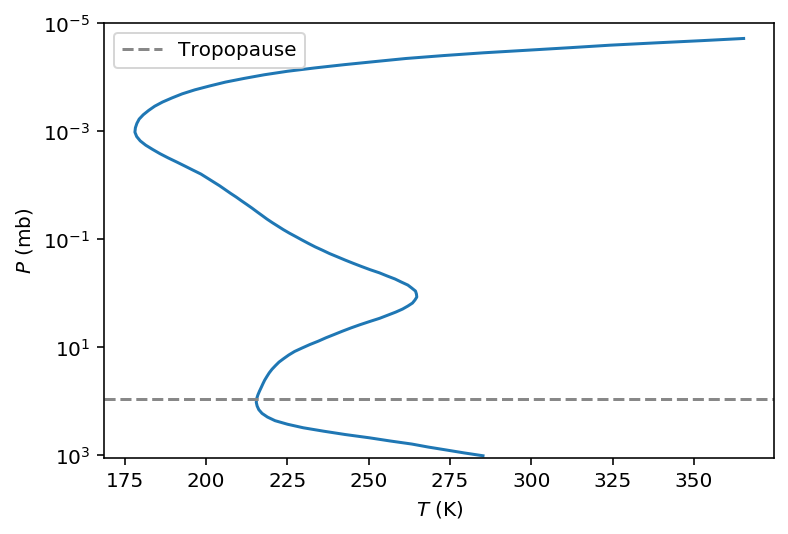

In [12]:
plt.plot(ngt_atm['TEM [K]'], ngt_atm['PRE [mb]'], label=None)
plt.axhline(ngt_atm.loc[17, 'PRE [mb]'], linestyle='dashed', color='#888888', label='Tropopause')
plt.ylim(1100, 1e-5); plt.yscale('log'); plt.ylabel('$P$ (mb)'); plt.xlabel('$T$ (K)');
plt.legend();

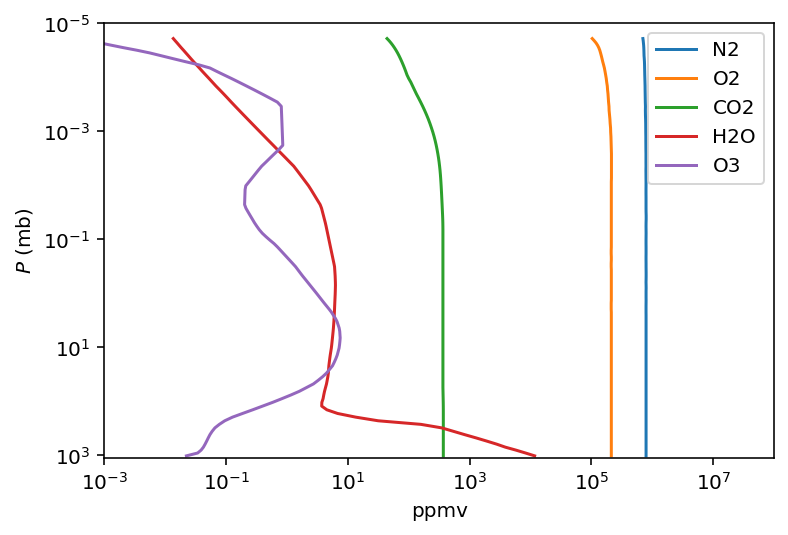

In [13]:
for species in ['N2', 'O2', 'CO2', 'H2O', 'O3']:
    plt.plot(ngt_atm[species+' [ppmv]'], ngt_atm['PRE [mb]'], label=species)
plt.ylim(1100, 1e-5); plt.yscale('log'); plt.ylabel('$P$ (mb)'); plt.xlabel('ppmv');
plt.xlim(1e-3, 1e8); plt.xscale('log'); plt.legend();

### Simulate an observation

In [14]:
@jit
def transmission_multilayer_atmosphere(T_vec, p_vec, vol_mix_ratio, nus, atomic_data=None):
    '''Compute transmission through a mutlilayer atmosphere'''
    
    return vmap(partial(transmission_of_T_p, atomic_data=atomic_data),
                in_axes=(0,0,None,0)
                )(T_vec, P_vec, nus, vol_mix_ratio).prod(axis=0)

In [15]:
wls = np.linspace(12600, 12800, 20000)

In [16]:
nus = np.array((wls*u.Angstrom).to(1/u.cm, equivalencies=u.spectral()).value)

In [17]:
nus.shape

(20000,)

In [18]:
import time

McDonald Observatory is at ~ 2km, so just read off from `2:` in steps of km.

In [19]:
T_vec, P_vec, H2O_vec = (np.array(ngt_atm['TEM [K]'].values[2:17]), 
           np.array(ngt_atm['PRE [mb]'].values/1013.25)[2:17],
           np.array(ngt_atm['H2O [ppmv]'].values*1.0e-6)[2:17])

Trim the linelist to the region of interest, with about 230 spectral lines.

In [20]:
O2_hitran_all = get_hapi_molec_data('O2')
mask = (O2_hitran_all[5] > nus.min()) & (O2_hitran_all[5] < nus.max())

In [21]:
O2_hitran = [arr[mask] for arr in O2_hitran_all]

In [22]:
O2_concentration_profile = np.array(ngt_atm['O2 [ppmv]'].values*1.0e-6)[2:17]

In [23]:
t0 = time.time()
O2_spectrum = transmission_multilayer_atmosphere(T_vec, P_vec, O2_concentration_profile, nus, 
                                          atomic_data=O2_hitran)

print(O2_spectrum[0], time.time() - t0)

0.99941456 0.3859541416168213


Now let's smooth it to the HPF resolution:

In [24]:
sig, mu = 16.5, 0.0
xx = np.linspace(-100, 100, 200)
slit_kernel = 1/(sig*np.sqrt(2*np.pi))*np.exp(-0.5*((xx-mu)/sig)**2) 

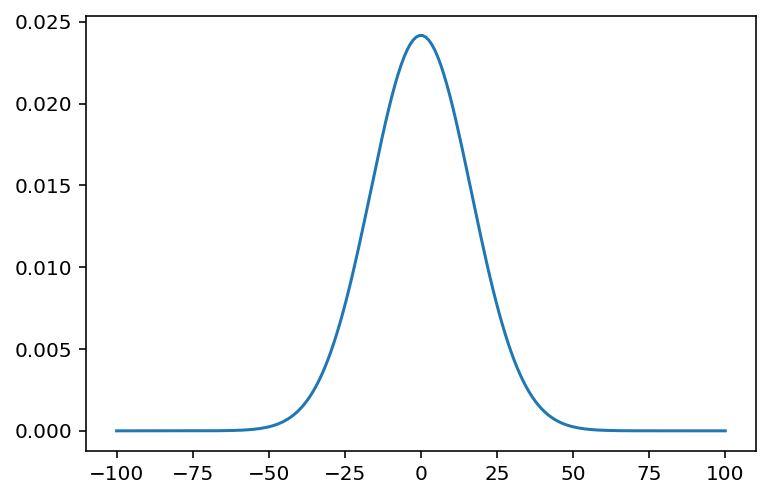

In [25]:
plt.plot(xx, slit_kernel)

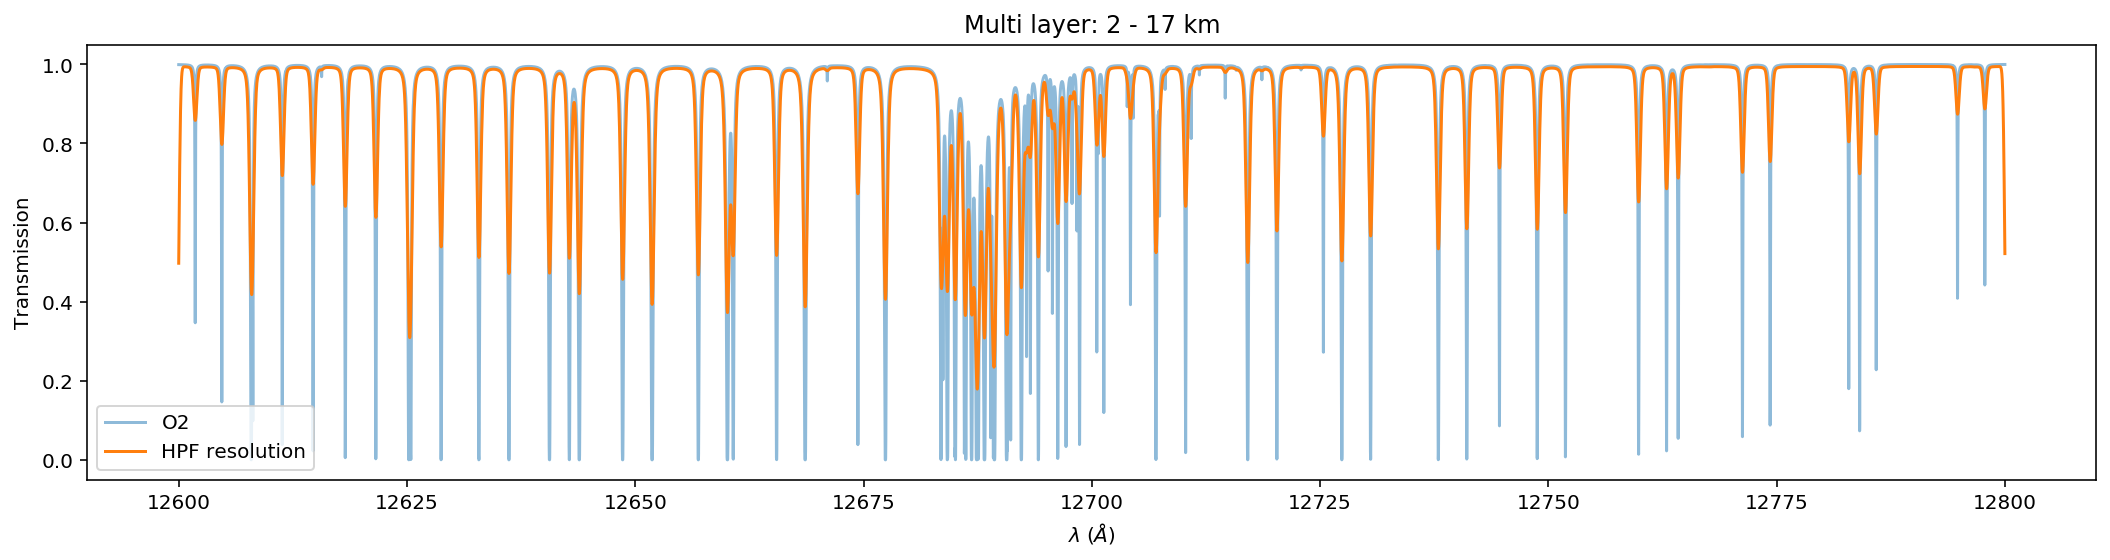

In [26]:
plt.figure(figsize=(18,4))
plt.plot(wls, O2_spectrum, label='O2', alpha=0.5)
plt.plot(wls, np.convolve(O2_spectrum, slit_kernel, mode='same'), label='HPF resolution')

plt.legend(loc='lower left')
plt.ylabel('Transmission')
plt.xlabel('$\lambda \;(\AA)$')
plt.title('Multi layer: 2 - 17 km');

## Mimic HPF resolution

In [27]:
from astropy.io import fits
from astropy.table import Table

hdus = fits.open('../../hopful/data/HPF/HPF_pipeline/HD_209458_OUT_A1/Slope-20191004T064513_R01_0014.optimal.fits')

df_all = pd.DataFrame()
for m in range(28):
    tab = Table({hdus[i].name:hdus[i].data[m,:] for i in range(1,10)})
    tab['order'] = m
    df_all = df_all.append(tab.to_pandas(), ignore_index=True)

In [28]:
df_all = df_all[(df_all.order ==27) & (df_all['Sci Flux']==df_all['Sci Flux'])].reset_index(drop=True)

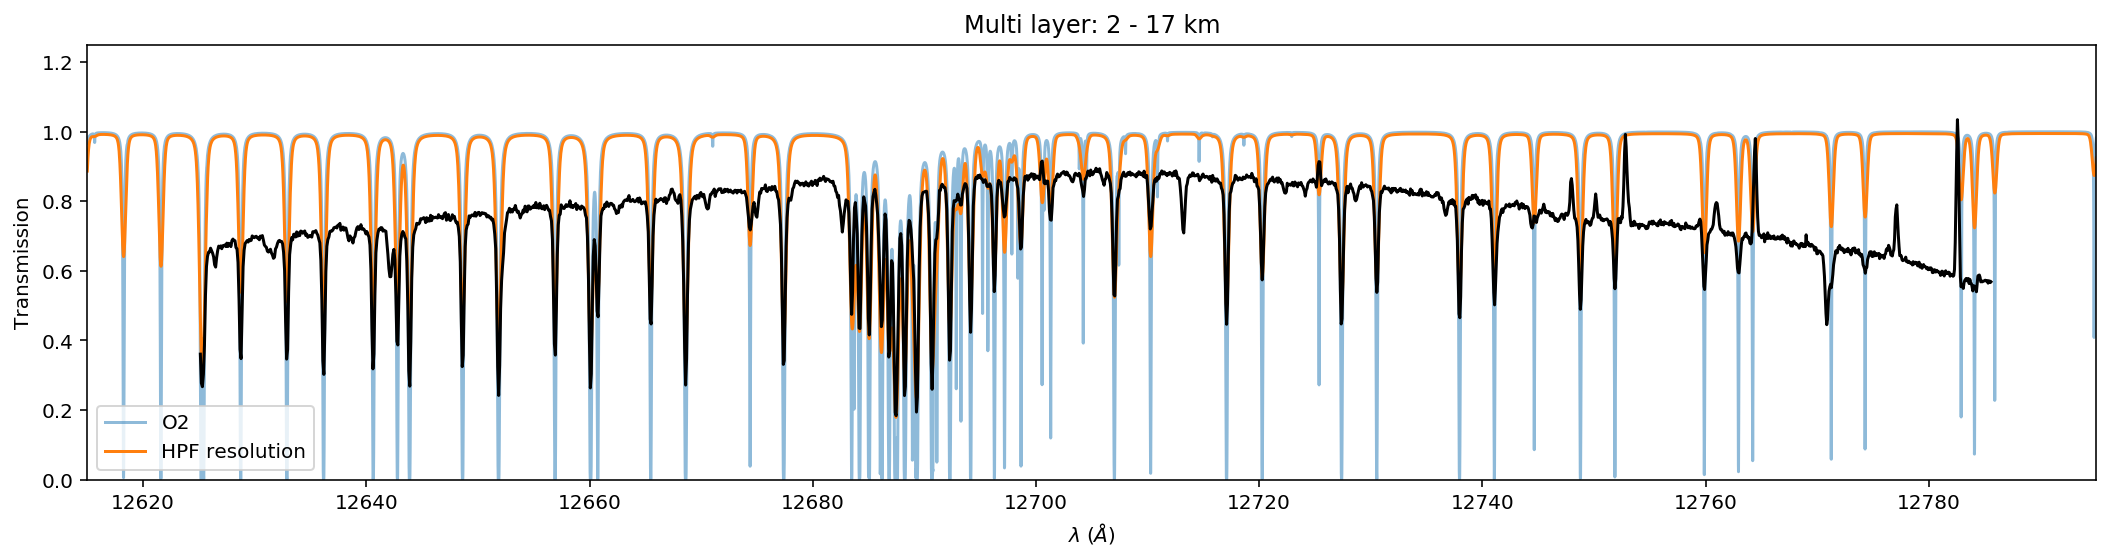

In [29]:
plt.figure(figsize=(18,4))

plt.plot(df_all['Sci Wavl'], df_all['Sci Flux']/80, color='k', zorder=10)

plt.plot(wls, O2_spectrum, label='O2', alpha=0.5)
plt.plot(wls, np.convolve(O2_spectrum, slit_kernel, mode='same'), label='HPF resolution')


plt.legend(loc='lower left')
plt.ylabel('Transmission')
plt.xlim(12615, 12795); plt.ylim(0,1.25)
plt.xlabel('$\lambda \;(\AA)$')
plt.title('Multi layer: 2 - 17 km');

Ok, close to the HPF resolution!

## Make synthetic data

In [30]:
wl_hpf = np.array(df_all['Sci Wavl'].values)

In [31]:
nu_hpf = np.array((wl_hpf*u.Angstrom).to(1/u.cm, equivalencies=u.spectral()).value)

In [32]:
noise_free_spectrum_native = transmission_multilayer_atmosphere(T_vec, P_vec, O2_concentration_profile, nus, 
                                          atomic_data=O2_hitran)

In [33]:
noise_free_spectrum_high_sampling = np.convolve(noise_free_spectrum_native, slit_kernel, mode='same')

In [34]:
wls.shape, wl_hpf.shape

((20000,), (2040,))

np.digitize was just merged as a pull request 8 days ago by Jake Vanderplas!  
https://github.com/google/jax/pull/3003  
We'd have to install the master version to get it to work, let's just use the original numpy version, which will ordinarily break backpropagation, but let's just fix the resolution (assume we know the velocity and instrumental resolution *perfectly*).

In [35]:
inds = np.array(np.digitize(wls, wl_hpf)) 
noise_free_spectrum = np.array([noise_free_spectrum_high_sampling[inds == i].mean() for i in range(2040)])

In [36]:
noise_free_spectrum.shape

(2040,)

In [37]:
sigma_noise = 0.002 # SNR 50 per pixel 
noise_draw = sigma_noise*random.normal(random.PRNGKey(312), shape=wl_hpf.shape)

In [38]:
synthetic_spectrum = noise_free_spectrum + noise_draw

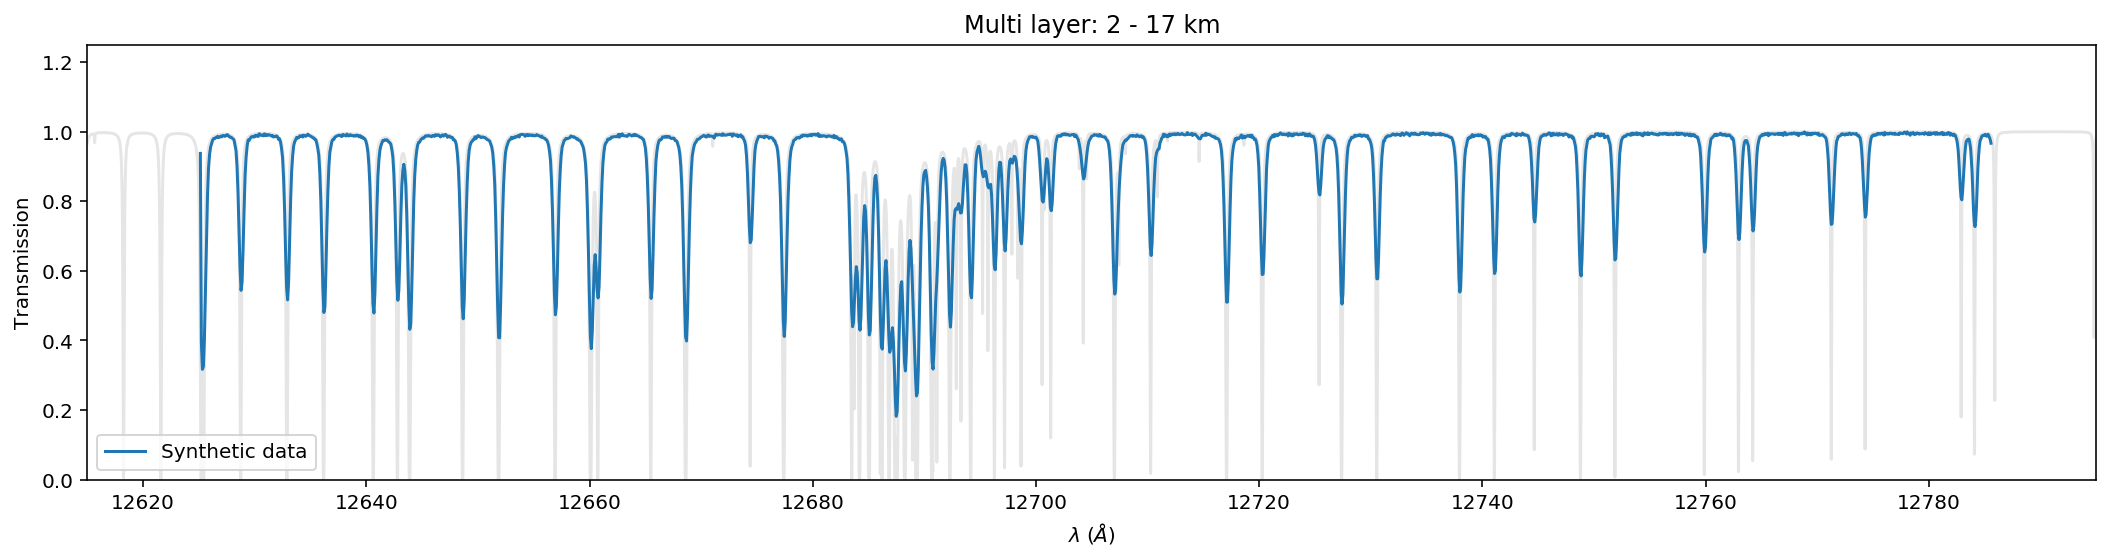

In [39]:
plt.figure(figsize=(18,4))

plt.plot(wls, noise_free_spectrum_native, color='k', alpha=0.1)
plt.plot(wl_hpf, synthetic_spectrum, label='Synthetic data')


plt.legend(loc='lower left')
plt.ylabel('Transmission')
plt.xlim(12615, 12795); plt.ylim(0,1.25)
plt.xlabel('$\lambda \;(\AA)$')
plt.title('Multi layer: 2 - 17 km');

Awesome!  It looks like real data.

In [40]:
@jit
def mean_model_func(T_input):
    '''Return the rebinned spectrum, uses global arrays for now'''
    noise_free_spectrum_native = transmission_multilayer_atmosphere(T_input, P_vec, 
                                                                    O2_concentration_profile, nus, 
                                                                    atomic_data=O2_hitran)
    noise_free_spectrum_high_sampling = np.convolve(noise_free_spectrum_native, slit_kernel, mode='same')
    rebinned_spectrum = np.array([noise_free_spectrum_high_sampling[inds == i].mean() for i in range(2040)])
    return rebinned_spectrum

## Hamiltonian MCMC with numpyro

In [41]:
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

In [42]:
def model(T_init):
    T_profs = numpyro.sample("T", dist.Normal(T_init, 130.1*np.ones(15)))
    #P_profs = numpyro.sample("P", dist.Normal(P_init, 0.02*np.ones(15)))
    #sigma = numpyro.sample("sigma", dist.Uniform(10.0, 11.0))
    
    mean_model = mean_model_func(T_profs)
    ## Oops, this 0.02 should be 0.002...  Fix next time
    TODO break
    numpyro.sample("obs", dist.Normal(mean_model, 0.02*np.ones(2040)), obs=synthetic_spectrum)

In [43]:
rng = random.PRNGKey(0)
rng, rng_ = random.split(rng)

# Run NUTS.
kernel = NUTS(model)

In [44]:
num_warmup, num_samples = 100, 3000

In [45]:
mcmc = MCMC(kernel, num_warmup, num_samples, num_chains=1)#, 
            #progress_bar=True, jit_model_args=True, chain_method='vectorized')

In [46]:
mcmc.run(rng_, T_vec, init_params={'T':T_vec})

sample: 100%|██████████| 3100/3100 [24:17<00:00,  2.13it/s, 31 steps of size 1.81e-01. acc. prob=0.92]  


In [47]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      T[0]    269.67     28.50    267.78    223.22    316.50   2441.79      1.00
      T[1]    264.38     28.86    263.22    216.28    309.17   4344.60      1.00
      T[2]    261.29     30.09    259.88    210.05    307.62   3388.62      1.00
      T[3]    257.60     29.67    255.63    209.84    306.37   2638.47      1.00
      T[4]    252.09     29.21    250.58    203.96    298.84   3866.59      1.00
      T[5]    248.62     29.93    246.95    200.94    299.65   4089.53      1.00
      T[6]    243.73     31.12    241.24    191.72    293.25   4085.45      1.00
      T[7]    238.30     30.59    235.73    187.25    287.24   3526.24      1.00
      T[8]    234.36     31.37    232.33    179.86    281.66   3163.01      1.00
      T[9]    230.81     31.54    228.70    178.58    281.14   3646.75      1.00
     T[10]    226.19     32.07    224.87    171.77    276.64   3478.35      1.00
     T[11]    221.50     32

In [48]:
samples = mcmc.get_samples(group_by_chain=False)

In [49]:
samples['T'].shape

(3000, 15)

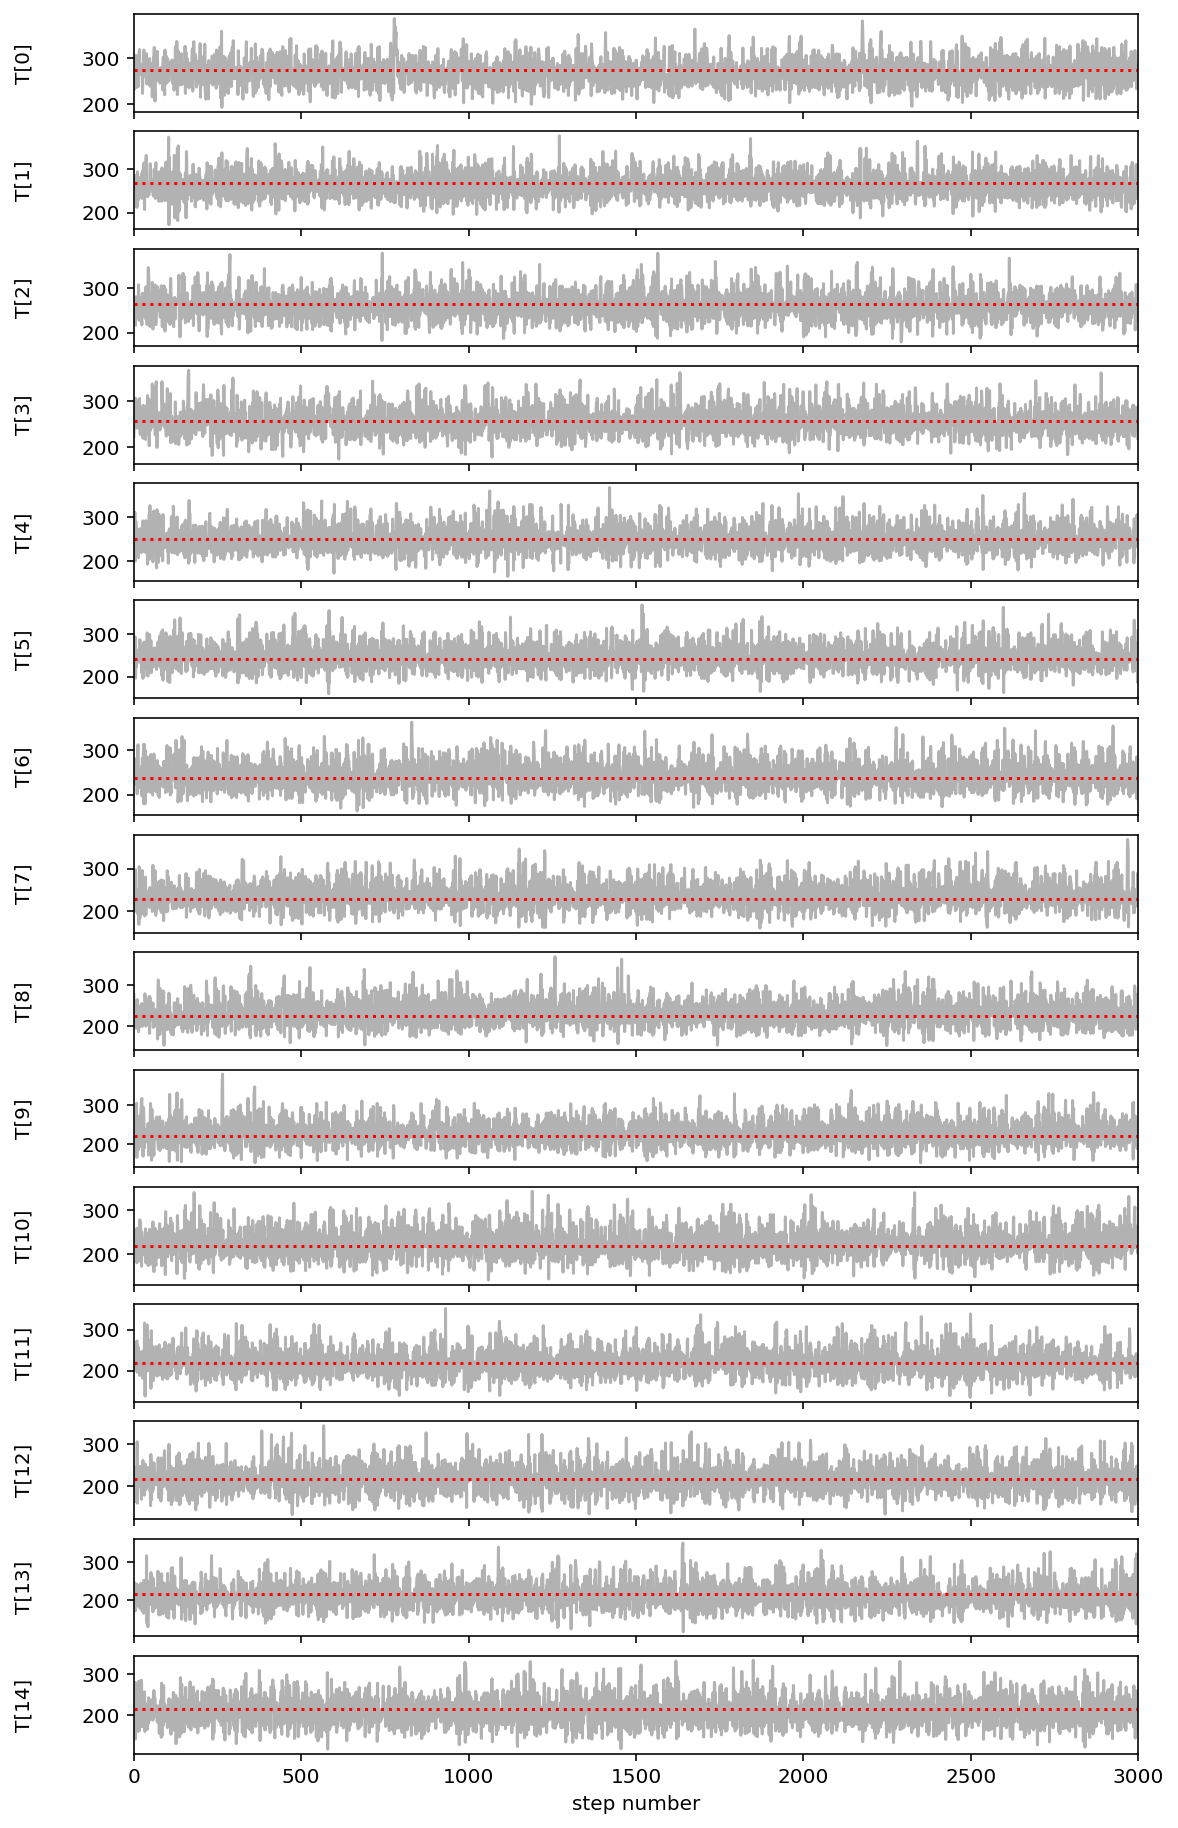

In [50]:
fig, axes = plt.subplots(15, figsize=(9, 16), sharex=True)
samples = mcmc.get_samples(group_by_chain=False)
for i in range(15):
    ax = axes[i]
    ax.plot(samples['T'][:,i], "k", alpha=0.3)
    ax.set_xlim(0, num_samples)
    ax.axhline(T_vec[i], color='r', linestyle='dotted')
    ax.set_ylabel('T[{}]'.format(i))
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

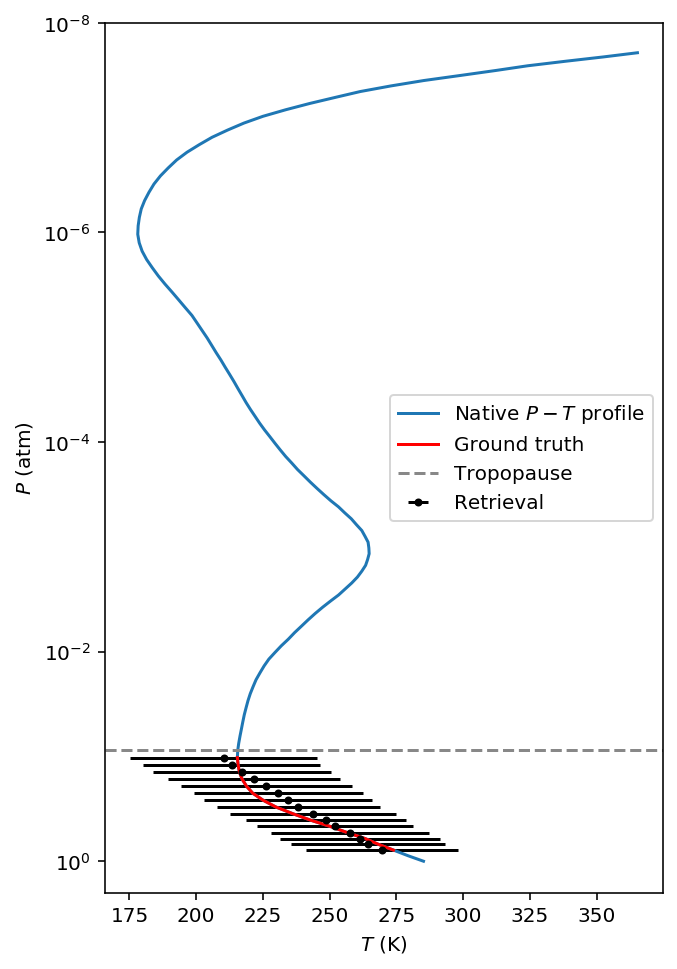

In [51]:
plt.figure(figsize=(5,8))
plt.plot(ngt_atm['TEM [K]'], ngt_atm['PRE [mb]']/1013.25, label='Native $P-T$ profile')
plt.errorbar(samples['T'].mean(axis=0), P_vec, xerr=samples['T'].std(axis=0), ecolor='k', 
             fmt='.', color='k', label='Retrieval')
plt.plot(T_vec, P_vec, color='r', label='Ground truth')

plt.axhline(ngt_atm.loc[17, 'PRE [mb]']/1013.25, linestyle='dashed', color='#888888', label='Tropopause')
plt.ylim(2, 1e-8); plt.yscale('log'); plt.ylabel('$P$ (atm)'); plt.xlabel('$T$ (K)');
plt.legend();
plt.yscale('log')

In [52]:
import numpy as onp

In [53]:
cov_mat = onp.corrcoef(samples['T'][1000:,:], rowvar=False)

In [54]:
import seaborn as sns

In [55]:
mask = 1-onp.diagflat(np.ones(15)*onp.NaN)

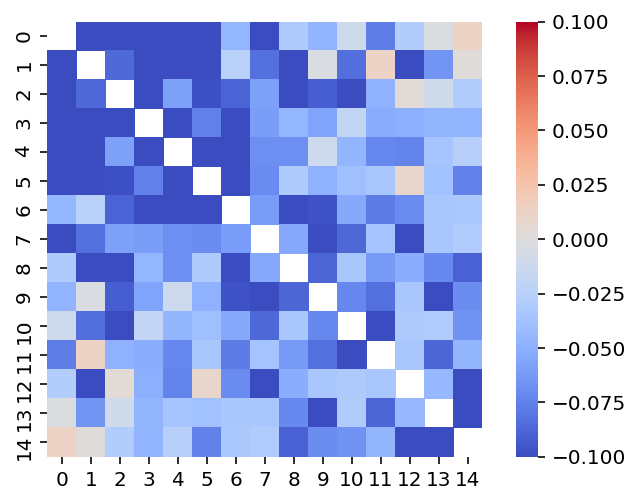

In [56]:
sns.heatmap(cov_mat*mask, square=True, vmin=-0.1, vmax=0.1, cmap='coolwarm');

Nice!  We see a similar appearance as the Fisher Information approach from the last notebook!  Todo-- multiply by the sigma values obtained above.